<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/RNA_Workshop/KZBG_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install scanpy
!pip install pybiomart
!pip install python-igraph
!pip install louvain
!pip install pynndescent
from IPython.display import clear_output
clear_output()


In [31]:
import os
import h5py
import numpy as np
import scipy as sci
import matplotlib as mpl
from matplotlib import pyplot as plt
import scanpy as sc
import tarfile
import os
import anndata as ad
import pandas as pd
import pybiomart
from tqdm import tqdm
from matplotlib.pyplot import rc_context


In [32]:
os.chdir("C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_ReAnalyze_Zalocusky_2021")

def publishable_plots(FS=6):
    plt.rcParams.update({'font.size': FS,'axes.linewidth':.5,'figure.dpi':300,
                         'xtick.major.width': 0.5,'ytick.major.width': 0.5,
                         'figure.titlesize':FS,'axes.titlesize': FS,'xtick.labelsize': FS,
                         'ytick.labelsize':FS,'axes.labelsize': FS,'legend.fontsize': FS,
                         'figure.labelsize':FS})

    import urllib.request
    arial_link = 'https://raw.githubusercontent.com/dtabuena/Resources/main/Fonts/arial.ttf'
    filename = './arial.ttf'
    urllib.request.urlretrieve(arial_link, filename)
    plt.rcParams.update({'font.family': 'arial'})
    return None


def seurat_cmap(bitdepth=256,orig=11,s=.65,v=1,alpha=1):
    orig=orig/360
    bits = np.linspace(orig,orig+1,num=bitdepth+3)
    colors = [list(mpl.colors.hsv_to_rgb([h, s, v]))+[alpha] for h in bits]
    return colors


publishable_plots()
sc.settings.set_figure_params(dpi=300, facecolor='white',fontsize=6,)

In [33]:
os.chdir("C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/Seurat_Scanpy/Scanpy_data/")
filename ='./zalocusky_2021_mouse_ApoE.h5ad'
kzbg_apoe_adata = sc.read_h5ad(filename)
display(kzbg_apoe_adata)
keys = list(np.arange(27))
seurat_id_order=[1,2,3,4,21,8,6,10,15,16,13,7,5,17,19,11,9,12,26,23,25,22,27,14,24,20,18]
seurat_id_order = [str(s) for s in seurat_id_order]
seurat_id_dict = { keys[i]:seurat_id_order[i] for i in range(len(seurat_id_order))   }
kzbg_apoe_adata.obs['res.0.6'] = [seurat_id_dict[int(c)] for c in  kzbg_apoe_adata.obs['res.0.6']]

AnnData object with n_obs × n_vars = 123489 × 21204
    obs: 'nGene', 'nUMI', 'orig.ident', 'sampleNumber', 'percent.mito', 'res.0.6', 'nCount_RNA', 'nFeature_RNA', 'group_vec'
    var: 'highly_variable'
    uns: 'pca'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'counts', 'data'

In [36]:
kzbg_apoe_adata.obs['group_vec']

AAACCTGAGAATGTTG-1     c(6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...
AAACCTGAGACTAAGT-1     c(6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...
AAACCTGAGGTGCACA-1     c(6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...
AAACCTGCACCCATGG-1     c(6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...
AAACCTGGTACGCTGC-1     c(6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...
                                             ...                        
TTTGTCATCAATCACG-32    c(6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...
TTTGTCATCGGTGTTA-32    c(6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...
TTTGTCATCTACTTAC-32    c(6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...
TTTGTCATCTGCGTAA-32    c(6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...
TTTGTCATCTGGTTCC-32    c(6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...
Name: group_vec, Length: 123489, dtype: object

In [34]:
age_bin_dict = {"5mo":'05mo', "10mo":'10mo', "14mo":'15_20m', "15mo":'15_20mo', "20mo":'15_20mo'}
kzbg_apoe_adata.obs['geno'] = [grp.split('_')[0] for grp in kzbg_apoe_adata.obs['group_vec']]
kzbg_apoe_adata.obs['age_bin'] = [age_bin_dict[grp.split('_')[1]] for grp in kzbg_apoe_adata.obs['group_vec']]


IndexError: ignored

C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


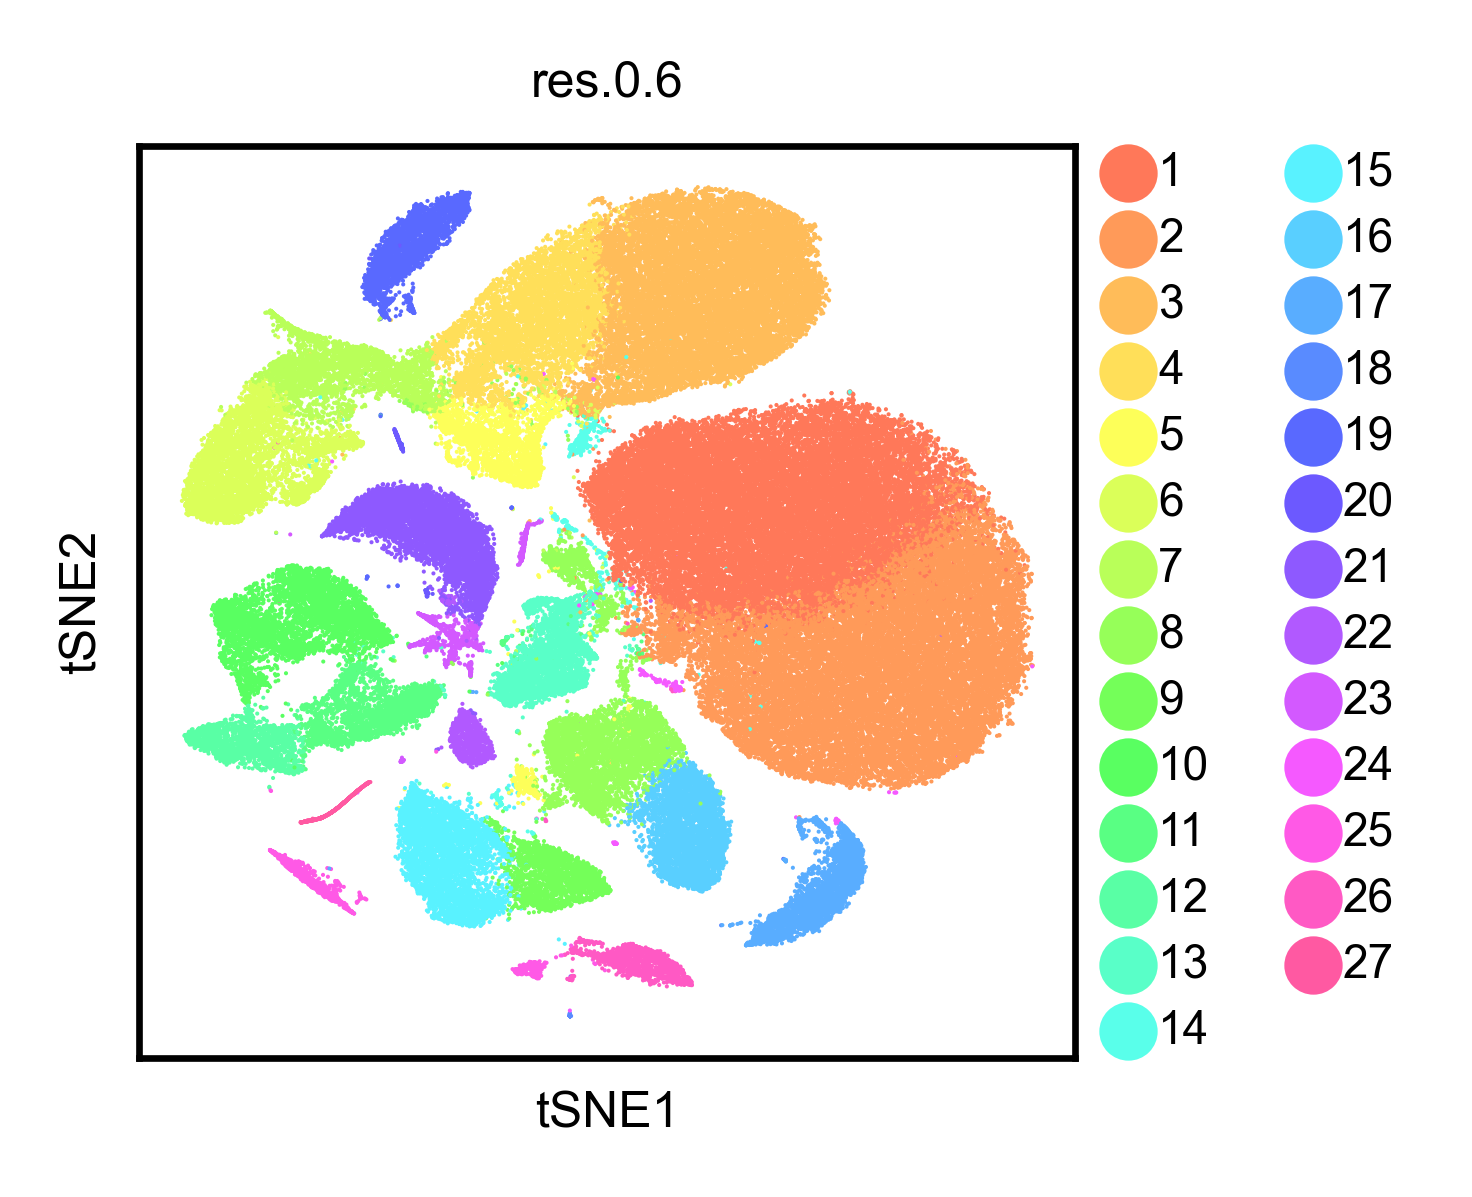

In [13]:

fig,ax =plt.subplots(1,figsize=[2,2])
sc.pl.tsne(kzbg_apoe_adata,color=['res.0.6'],palette=seurat_cmap(27,s=.65,v=1),ax=ax) # ,legend_loc='on data'


In [45]:
display(kzbg_apoe_adata.obs)
kzbg_KO_adata.obs

ValueError: ignored

ValueError: ignored

,nGene,nUMI,orig.ident,percent.mito,res.0.6,Sample,Cells,Reads.Cell,Sample.Description,Apoe,KO,animal_ID,nCount_RNA,nFeature_RNA
AAACCTGAGTTTAGGA-9,1375,2564.0,apoe_SeuratObj_20190401,0.002730,0,YH_KZ03_09,3249,126341,ApoE-KO_B,KO,KO,B,2564.0,1375
AAACCTGGTCATACTG-9,574,958.0,apoe_SeuratObj_20190401,0.001044,0,YH_KZ03_09,3249,126341,ApoE-KO_B,KO,KO,B,958.0,574
AAACGGGGTTGTACAC-9,1564,2875.0,apoe_SeuratObj_20190401,0.002783,0,YH_KZ03_09,3249,126341,ApoE-KO_B,KO,KO,B,2875.0,1564
AAACGGGTCTTGCATT-9,1337,2500.0,apoe_SeuratObj_20190401,0.002000,0,YH_KZ03_09,3249,126341,ApoE-KO_B,KO,KO,B,2500.0,1337
AAAGATGGTATAGTAG-9,884,1466.0,apoe_SeuratObj_20190401,0.000000,0,YH_KZ03_09,3249,126341,ApoE-KO_B,KO,KO,B,1466.0,884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCTTTCCGTGTTTGTG-10,1135,2093.0,apoe_SeuratObj_20190401,0.000000,16,YH_KZ03_10,3837,112151,ApoE-KO_C,KO,KO,C,2093.0,1135
TGAAAGAAGTCGAGTG-10,918,1620.0,apoe_SeuratObj_20190401,0.000617,16,YH_KZ03_10,3837,112151,ApoE-KO_C,KO,KO,C,1620.0,918
TGAGAGGGTACTTCTT-10,1216,2124.0,apoe_SeuratObj_20190401,0.004237,16,YH_KZ03_10,3837,112151,ApoE-KO_C,KO,KO,C,2124.0,1216
TTAGTTCGTATGCTTG-10,1591,3285.0,apoe_SeuratObj_20190401,0.003349,16,YH_KZ03_10,3837,112151,ApoE-KO_C,KO,KO,C,3285.0,1591


AnnData object with n_obs × n_vars = 6331 × 27998
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'res.0.6', 'Sample', 'Cells', 'Reads.Cell', 'Sample.Description', 'Apoe', 'KO', 'animal_ID', 'nCount_RNA', 'nFeature_RNA'
    var: 'highly_variable'
    uns: 'pca'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'counts', 'data'

C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


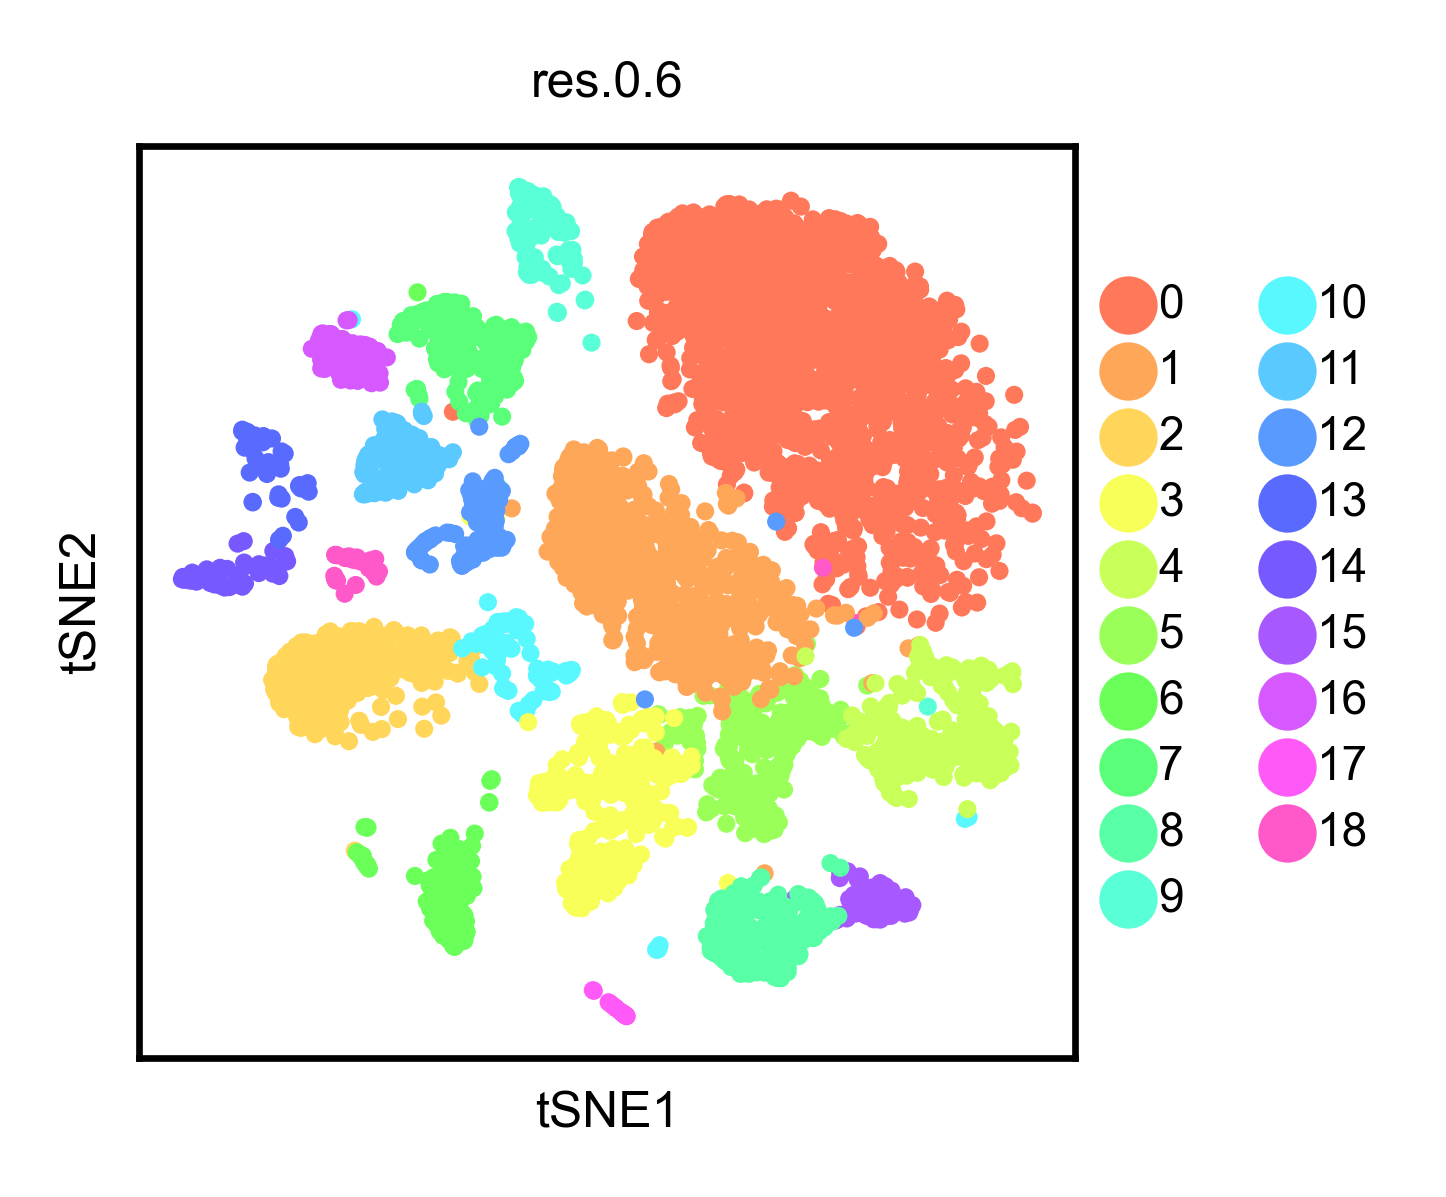

In [44]:
os.chdir("C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/Seurat_Scanpy/Scanpy_data/")
filename ='./zalocusky_2021_mouse_ApoE-KO.h5ad'
kzbg_KO_adata = sc.read_h5ad(filename)
display(kzbg_KO_adata)
fig,ax =plt.subplots(1,figsize=[2,2])
sc.pl.tsne(kzbg_KO_adata,color='res.0.6',palette=seurat_cmap(len(set(kzbg_KO_adata.obs['res.0.6'])),s=.65,v=1),ax=ax)

In [42]:
print(set( kzbg_KO_adata.obs['KO']))
print(set( kzbg_KO_adata.obs['animal_ID']))
print(set( kzbg_KO_adata.obs['Apoe']))
print(set( kzbg_KO_adata.obs['Sample.Description']))
print(set( kzbg_KO_adata.obs['Sample']))

{'KO'}
{'C', 'B'}
{'KO'}
{'ApoE-KO_C', 'ApoE-KO_B'}
{'YH_KZ03_10', 'YH_KZ03_09'}


In [9]:
# sc.tl.pca(kzbg_KO_adata, svd_solver='arpack')
# sc.tl.pca(kzbg_apoe_adata, svd_solver='arpack')


In [10]:
# overlap_var_names = kzbg_apoe_adata.var_names.intersection(kzbg_KO_adata.var_names)
# print(overlap_var_names)
# kzbg_apoe_adata = kzbg_apoe_adata[:, overlap_var_names]
# kzbg_KO_adata = kzbg_KO_adata[:, overlap_var_names]

In [11]:
# sc.pp.neighbors(kzbg_KO_adata, n_neighbors=10, n_pcs=40)
# sc.pp.neighbors(kzbg_apoe_adata, n_neighbors=10, n_pcs=40)

In [12]:
# display(kzbg_KO_adata.obs.head(5))
#
